# Travel times
##Description:	
A driver uses an app to track GPS coordinates as he drives to work and back each day. The app collects the location and elevation data. Data for about 200 trips are summarized in this data set.
##Data source:	
* Date of travel
* StartTime: when getting into the car
* DayOfWeek: the day name
* GoingTo: direction of travel
* Distance travelled in kilometers
* MaxSpeed: fastest speed recorded (all trips are on the 407 highway for some portion)
* AvgSpeed: the average speed for the entire trip
* AvgMovingSpeed: the average speed recorded only while the car is moving
* FuelEconomy: a rough estimate of fuel economy (it is inaccurate)
* TotalTime: duration of the entire trip, in minutes
* MovingTime: duration when the car was considered to be moving (i.e. not counting traffic delays, accidents, or time while the car is stationary)
* Take407All: is Yes if the 407 toll highway was taken for the entire trip. I try to avoid taking the 407, taking slower back routes to save costs. But some days I'm running late, or just lazy, and take it all the way.

##Comments
* Data shape:	205 rows and 13 columns
* Usage restrictions:	None
* Contact person:	Kevin Dunn
* Contact details:	datasets@connectmv.com
* Added here on:	17 September 2015
* Last updated:	09 January 2012 13:21

#Task

Build a regression model to predict the total travel time.

##Extension
Many of the data points in this data set are only available _after_ the drive. But what if we want to predict how long it will take _before_ we leave?

Build a model that makes a prediction based only on data available to the driver _before_ they leave?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


##1. Read the data into a data frame using pandas.

In [2]:
df = pd.read_csv('data/travel-times.csv')
df.head()

,Date,StartTime,DayOfWeek,GoingTo,Distance,MaxSpeed,AvgSpeed,AvgMovingSpeed,FuelEconomy,TotalTime,MovingTime,Take407All,Comments
0,1/6/2012,16:37,Friday,Home,51.29,127.4,78.3,84.8,NaN,39.3,36.3,No,NaN
1,1/6/2012,08:20,Friday,GSK,51.63,130.3,81.8,88.9,NaN,37.9,34.9,No,NaN
2,1/4/2012,16:17,Wednesday,Home,51.27,127.4,82.0,85.8,NaN,37.5,35.9,No,NaN
3,1/4/2012,07:53,Wednesday,GSK,49.17,132.3,74.2,82.9,NaN,39.8,35.6,No,NaN
4,1/3/2012,18:57,Tuesday,Home,51.15,136.2,83.4,88.1,NaN,36.8,34.8,No,NaN


##2. Create X and y matrices

Take only the columns which have numeric values and make that the `X` matrix. Make the `TotalTime` the `y` vector. Make sure that the Total Time *isn't* in your X matrix!

In [3]:
regression_columns = ['Distance', 'MaxSpeed', 'AvgSpeed', 'AvgMovingSpeed', 'MovingTime']
X = df[regression_columns].values
y = df['TotalTime'].values

##3. Build a baseline KNN model with k=10

In [4]:
from sklearn.neighbors import KNeighborsRegressor

baseline = KNeighborsRegressor(n_neighbors=10)
baseline.fit(X, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_neighbors=10, p=2, weights='uniform')

## 4. Calculate the root mean squared error of the baseline.

In [5]:
from sklearn.metrics import mean_squared_error

predict = baseline.predict(X)
np.sqrt(mean_squared_error(predict, df.TotalTime))

2.7731230083629885

## Challenge 1: Use Cross-Validation to compare performance of different values of k.

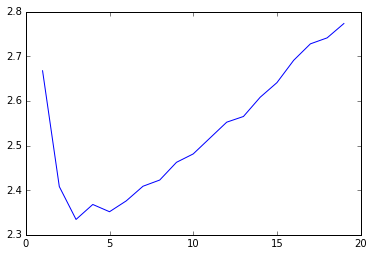

In [6]:
from sklearn.cross_validation import KFold

# function from lecture notes
def kfold_cv_error(model, X, y, folds):
    test_error = []
    for train_index, test_index in folds:
        model.fit(X[train_index], y[train_index])
        predict = model.predict(X[test_index])
        fold_error = np.sqrt(mean_squared_error(y[test_index], predict))
        test_error.append(fold_error)
    return np.mean(test_error)

#What values of k to test.
neighbors = range(1, 20)
#What errors for those k
folds = KFold(df.shape[0], n_folds=10)
errors = [kfold_cv_error(KNeighborsRegressor(k), X, y, folds) for k in neighbors]

plt.plot(neighbors, errors)

## Challenge 2: Transform non-numeric data

* Make the `Take407All` variable a boolean column.
* Make the `GoingTo` column a boolean column.
* Make the pandas function `get_dummies` to create dummy columns for the DayOfWeek

In [7]:
df['Take407All_bool'] = df['Take407All'] == 'Yes'
df['GoingHome_bool'] = df['GoingTo'] == 'Home'
columns = regression_columns + ['Take407All_bool', 'GoingHome_bool']
tt_transformed = pd.concat([df[regression_columns],
                            pd.get_dummies(df['DayOfWeek'])], axis=1)
tt_transformed.head()

,Distance,MaxSpeed,AvgSpeed,AvgMovingSpeed,MovingTime,Friday,Monday,Thursday,Tuesday,Wednesday
0,51.29,127.4,78.3,84.8,36.3,1,0,0,0,0
1,51.63,130.3,81.8,88.9,34.9,1,0,0,0,0
2,51.27,127.4,82.0,85.8,35.9,0,0,0,0,1
3,49.17,132.3,74.2,82.9,35.6,0,0,0,0,1
4,51.15,136.2,83.4,88.1,34.8,0,0,0,1,0


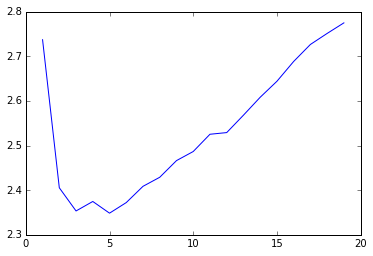

In [8]:
X_transformed = tt_transformed.values

neighbors = range(1, 20)
folds = KFold(df.shape[0], n_folds=10)
errors = [kfold_cv_error(KNeighborsRegressor(k), X_transformed, y, folds) for k in neighbors]

plt.plot(neighbors, errors)